In [1]:
import tempfile
import os
import zipfile
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model
from tensorflow import keras

In [2]:
%load_ext tensorboard


In [3]:
from sklearn.datasets import make_friedman1
X, y = make_friedman1(n_samples=10000, n_features=10, random_state=0)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model Without Prunning

In [6]:
def setup_model():
    model = keras.Sequential([
    keras.layers.Dense(units = 128, activation='relu',input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=1, activation='relu')])
    return model

In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [8]:
model = setup_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse'])

In [11]:
model.fit(X_train,y_train,epochs=300,validation_split=0.2,callbacks=early_stop,verbose=0)


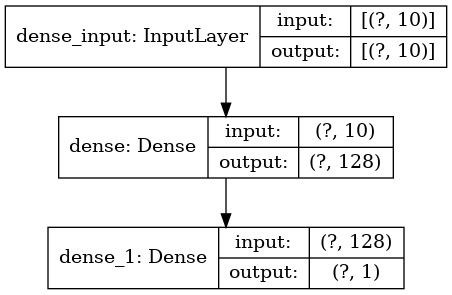

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
predictions = model.predict(X_test)

In [15]:
print('Without Prunning MSE %.4f' % mean_squared_error(y_test,predictions.reshape(3300,)))

Without Prunning MSE 0.0301


# Prunning the Entire Model ConstantSparsity Pruning Schedule

In [16]:
from tensorflow_model_optimization.sparsity.keras import ConstantSparsity
pruning_params = {
    'pruning_schedule': ConstantSparsity(0.5, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

In [17]:
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
model_to_prune = prune_low_magnitude(
    keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='relu')
    ]), **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [18]:
model_to_prune.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense_2  (None, 128)               2690      
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 1)                 259       
Total params: 2,949
Trainable params: 1,537
Non-trainable params: 1,412
_________________________________________________________________


In [19]:
model_to_prune.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse'])

In [20]:
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

In [21]:
model_to_prune.fit(X_train,y_train,epochs=100,validation_split=0.2,callbacks=callbacks,verbose=0)

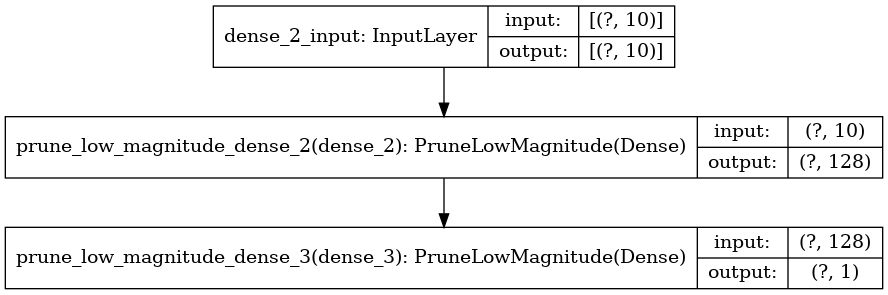

In [22]:
tf.keras.utils.plot_model(
    model_to_prune,
    to_file="model_to_prune.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [23]:
prune_predictions = model_to_prune.predict(X_test)

In [24]:
print('Whole Model Pruned MSE %.4f' %  mean_squared_error(y_test,prune_predictions.reshape(3300,)))

Whole Model Pruned MSE 2.3929


# Prunning the Dense Layer Only with PolynomialDecay Pruning Schedule

In [25]:
from tensorflow_model_optimization.sparsity.keras import PolynomialDecay
layer_pruning_params = {
    'pruning_schedule': PolynomialDecay(initial_sparsity=0.2,
        final_sparsity=0.8, begin_step=1000, end_step=2000),
    'block_size': (2, 3),
    'block_pooling_type': 'MAX'
}

model_layer_prunning = keras.Sequential([
    prune_low_magnitude(tf.keras.layers.Dense(128, activation='relu',input_shape=(X_train.shape[1],)),
                        **layer_pruning_params),
    tf.keras.layers.Dense(1, activation='relu')
])

In [26]:
model_layer_prunning.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense_4  (None, 128)               2690      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,819
Trainable params: 1,537
Non-trainable params: 1,282
_________________________________________________________________


In [27]:
model_layer_prunning.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse'])

In [28]:
model_layer_prunning.fit(X_train,y_train,epochs=300,validation_split=0.1,callbacks=callbacks,verbose=0)

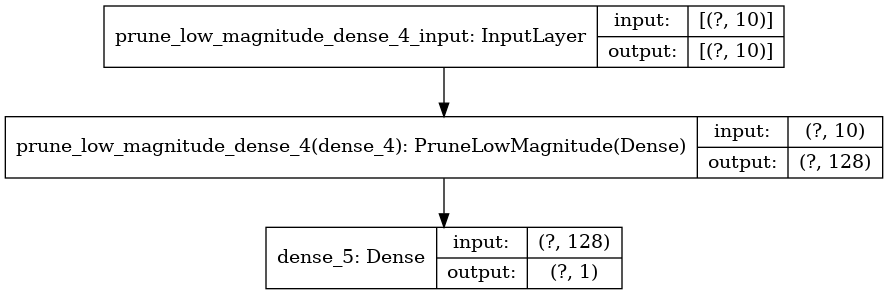

In [29]:
tf.keras.utils.plot_model(
    model_layer_prunning,
    to_file="model_to_prune.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [30]:
layer_prune_predictions = model_layer_prunning.predict(X_test)

In [31]:
print('Layer Prunned MSE %.4f' %  mean_squared_error(y_test,layer_prune_predictions.reshape(3300,)))

Layer Prunned MSE 0.0462


# Comparing Model Sizes

In [32]:
def train_save_weights():
    model = setup_model()
    model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse'])
    model.fit(X_train,y_train,epochs=300,validation_split=0.2,callbacks=callbacks,verbose=0)
    model.save_weights('friedman_model_weights.h5')

In [33]:
train_save_weights()

In [34]:
base_model = setup_model()
base_model.load_weights('friedman_model_weights.h5') 

In [35]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [36]:
base_predictions = base_model.predict(X_test)

In [37]:
print('Base Model MSE %.4f' %  mean_squared_error(y_test,base_predictions.reshape(3300,)))

Base Model MSE 0.0738


In [38]:
base_model = setup_model()
base_model.load_weights('friedman_model_weights.h5') # optional but recommended for model accuracy
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(base_model)

log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

model_for_pruning.compile(
      loss=tf.keras.losses.mean_squared_error,
      optimizer='adam',
      metrics=['mae', 'mse']
)

model_for_pruning.fit(
    X_train,
    y_train,
    callbacks=callbacks,
    epochs=300,
    validation_split = 0.2,
    verbose=0
)

%tensorboard --logdir={log_dir}

In [39]:
def get_gzipped_model_size(model,mode_name,zip_name):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    model.save(mode_name, include_optimizer=False)

    with zipfile.ZipFile(zip_name, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(mode_name)

    return os.path.getsize(zip_name)

In [40]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [41]:
print("Size of gzipped pruned model without stripping: %.2f bytes" % (get_gzipped_model_size(model_for_pruning,'model_for_pruning.h5','model_for_pruning.zip')))
print("Size of gzipped pruned model with stripping: %.2f bytes" % (get_gzipped_model_size(model_for_export,'model_for_export.h5','model_for_export.zip')))

Size of gzipped pruned model without stripping: 6126.00 bytes
Size of gzipped pruned model with stripping: 5161.00 bytes


In [42]:
model_for_prunning_predictions = model_for_pruning.predict(X_test)

In [43]:
print('Model for Prunning Error %.4f' %  mean_squared_error(y_test,model_for_prunning_predictions.reshape(3300,)))

Model for Prunning Error 0.0375


In [44]:
model_for_export_predictions = model_for_export.predict(X_test)

In [45]:
print('Model for Export Error %.4f' %  mean_squared_error(y_test,model_for_export_predictions.reshape(3300,)))

Model for Export Error 0.0375


<Figure size 864x432 with 0 Axes>

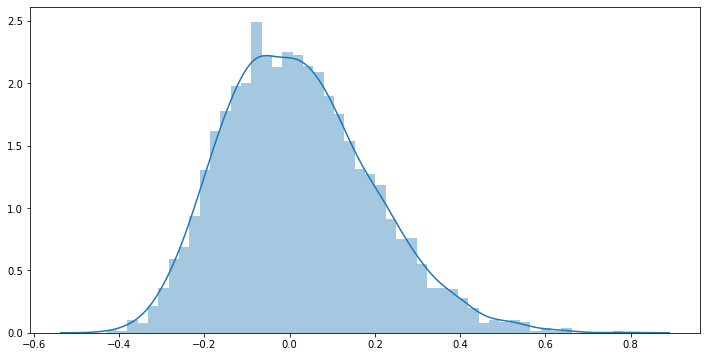

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.distplot((y_test-predictions.reshape(3300,)),bins=50)

Happy Coding!